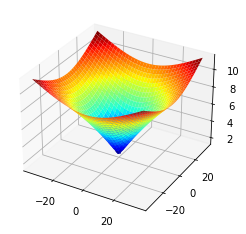

Found minimum at [0.0625, -0.3125] with value: 1.1595378657349045, it took 7 iterations


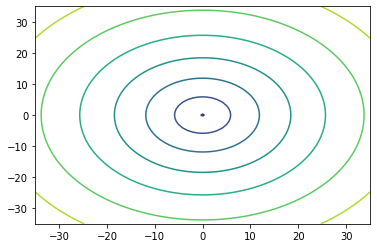

In [3]:
# Import packages
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Calculate ackley 
def ackley(X, Y):
    Z = np.zeros((len(X), len(Y)))
    
    factor_1 = -0.02 * np.sqrt(0.5 * (X * X + Y * Y))
    factor_2 = 0.5 * (np.cos(2 * np.pi * X + np.cos(2 * np.pi * Y)))
    
    Z = -20 * np.exp(factor_1) - np.exp(factor_2) + np.exp(1) + 20

    return Z

# Define plotting ackley
def plot_ackley (X, Y, Z):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z, cmap='jet')
    plt.show()

# Define plotting ackley contour
def plot_ackley_contour (X, Y, Z):
    ax = plt.axes()
    ax.contour(X, Y, Z)

# Calculate ackley scalar value
def ackley_scalar (x, y):
    factor_1 = -0.02 * np.sqrt(0.5 * (x * x + y * y))
    factor_2 = 0.5 * (np.cos(2 * np.pi * x + np.cos(2 * np.pi * y)))

    return -20 * np.exp(factor_1) - np.exp(factor_2) + np.exp(1) + 20

# Find minimum using Hook-Jeeves algorithm
def hooke_jeeves (SP, step_length, tolerance, step_factor):
    B_x = [[1,0],[-1,0],[0,0]]
    B_y = [[0,1],[0,-1],[0,0]] 
    best_coord = SP
    best_value = ackley_scalar(SP[0], SP[1])
    temp_coord = best_coord
    temp_value = best_value
    i = 0
    
    while step_length >= tolerance:

        # Chose best point from X axis
        for possible_step in B_x:
            test_value = ackley_scalar(best_coord[0] + possible_step[0] * step_length, best_coord[1] + possible_step[1] * step_length)
            if test_value < best_value and test_value < temp_value:
                temp_value = test_value
                temp_coord = [best_coord[0] + possible_step[0] * step_length, best_coord[1] + possible_step[1] * step_length]

        # Chose best point from Y axis
        for possible_step in B_y:
            test_value = ackley_scalar(temp_coord[0] + possible_step[0] * step_length, temp_coord[1] + possible_step[1] * step_length)
            if test_value < best_value and test_value < temp_value:
                temp_value = test_value
                temp_coord = [temp_coord[0] + possible_step[0] * step_length, temp_coord[1] + possible_step[1] * step_length]

        # Calculate vector
        slope_vector = [temp_coord[0] - best_coord[0], temp_coord[1] - best_coord[1]]

        # Move point along the vector until find worse value
        while temp_value < best_value:
            best_coord = temp_coord
            best_value = temp_value
            temp_coord = best_coord[0] + slope_vector[0], best_coord[1] + slope_vector[1]
            temp_value = ackley_scalar(temp_coord[0], temp_coord[1])
            i += 1

        # Reduct step length
        step_length *= step_factor

    return {
        'best_coord': best_coord,
        'best_value': best_value,
        'iterations': i,
    }

# Prepare range
wek_x = np.arange(-35,36,1)
wek_y = np.arange(-35,36,1)

X, Y = np.meshgrid(wek_x, wek_y)

# Calculate ackley and plot
Z = ackley(X, Y)

plot_ackley(X, Y, Z)

plot_ackley_contour(X, Y, Z)

# Init variables for searching minimum (Hook-Jeeves alghoritm)
SP = (35,-32)           # Starting position 
SL = 6.5                # Initial step length
E = 0.1                 # Tolerance, minimum step length
SF = 0.5                # Step factor, step length reduction 

# Run Hook-Jeeves algorithm
result = hooke_jeeves(SP, SL, E, SF)
print(f"Found minimum at {result['best_coord']} with value: {result['best_value']}, it took {result['iterations']} iterations.")